In [1]:
import zipfile

import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import svds
from tqdm import tqdm

from dataprep import transform_indices, reindex_data, generate_interactions_matrix
from evaluation import downvote_seen_items, topn_recommendations

# getting data from Kaggle

In [2]:
competition_name = "skoltech-recommender-systems-challenge-2023"

In [8]:
!kaggle competitions download -c {competition_name}

 98%|█████████████████████████████████████▎| 86.0M/87.6M [00:03<00:00, 37.6MB/s]
100%|██████████████████████████████████████| 87.6M/87.6M [00:03<00:00, 26.5MB/s]


In [9]:
with zipfile.ZipFile("skoltech-recommender-systems-challenge-2023.zip","r") as z:
    z.extractall(".")

In [39]:
training_source = pd.read_csv('training')

In [40]:
testset_source = pd.read_csv('testset')

# Convenience functions

In [41]:
def plot_monthly_activity(data, ax=None, label=None, timeid='timestamp'):
    return (data
        .set_index(pd.to_datetime(data[timeid], unit='s'))
        .resample('M').size()
        .plot(ax=ax, logy=True, label=label, xlabel='Month',
              title='Monthly rating activity', legend=label is not None)
    )

## data splitting

In [42]:
def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the `warm-start` evaluation strategy.

    Parameters
    ----------
    data : pd.DataFrame
        The input dataset containing columns `userid`, `movieid`, and `timestamp`.
    time_split_q : float, optional
        The quantile value used to split the dataset based on the `timestamp` column.
        Default is 0.95.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of three pandas DataFrames: training, testset, and holdout.
        `training` is a subset of `data` used for training the recommender system.
        `testset` is a subset of `data` used for generating recommendations for the test users.
        `holdout` is a subset excluded from `testset` containing only the most recent interactions for each test user.

    Notes
    -----
    The function splits the input `data` into three subsets: `training`, `testset`, and `holdout`.
    The split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value.
    The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`.
    The set of users in `training` is disjoint with the set of users in the `testset`, which implements the `warm-start` scenario.
    """    
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)
    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['userid'], keep='first')
    )
    # the holdout dataframe contains interactions closest to certain timepoint from the right,
    # i.e., the corresponding items are the first in each test user profile after this timepoint
    training = rest_.query('userid not in @holdout_.userid')
    train_items = training.movieid.unique()
    testset_ = rest_.query('userid in @holdout_.userid and movieid in @train_items')
    test_users = testset_.userid.unique()
    holdout = holdout_.query(
        # if user is not in `test_users` then no evluation is possible,
        # if item is not in `train_items` it's cold start -> must be excluded
        'userid in @test_users and movieid in @train_items'
    ).sort_values('userid')
    testset = testset_.query(
        # make sure testset and holdout contain the same set of users
        'userid in @holdout.userid'
    ).sort_values('userid')
    return training, testset, holdout

## kaggle solution format

In [43]:
def save_solution(recs_array, useridx, itemidx, filepath):
    """
    Save a solution for Kaggle competition in the required format.

    Parameters 
    ----------
    recs_array (numpy.ndarray): Array of recommended items. 
    useridx (pandas.Index): Test user indices in the original (source) representation. 
    itemidx (pandas.Index): Mapping from internal to orignial representation of item indices. 
    filepath (str): Path to save the solution file. 

    Returns
    -------
    None: The function saves the solution file in the csv format at the specified path. 

    Notes
    -----
    The code creates a dataframe containing user IDs and a list of recommended items for each user.
    It then melts the dataframe so that each row contains one recommended item per user.
    Finally, it saves the melted dataframe to a file at the specified filepath.
    """
    rec_items = itemidx.take(recs_array).values
    solution = pd.DataFrame({
        'userid': useridx,
        'movieid': [list(recs) for recs in rec_items]
    })
    sol_melt = solution.set_index('userid')['movieid'].explode().reset_index()
    sol_melt.to_csv(filepath, index=False)

To submit a solution, you can use he following command directly from a notebook cell:  

```
!kaggle competitions submit -c {competition_name} -f {filepath} -m 'my new submission'
```

In [53]:
def transform_data(train, test, holdout=None, userid='userid', itemid='movieid'):
    train_new, data_index = transform_indices(train, 'userid', 'movieid')
    testset_new = reindex_data(test, data_index, fields='items')
    if holdout is None:
        return train_new, testset_new, data_index
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, testset_new, holdout_new, data_index


train_val, testset_val, holdout_val, data_index = transform_data(train_val_, testset_val_, holdout_val, userid='userid', itemid='movieid')

In [54]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items'])
)

# Evaluation setup

In [55]:
topn = 20

In [56]:
def evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    # NDCG
    ndcg_pu = 1.0 / np.log2(hit_rank + 1)
    ndcg = np.sum(ndcg_pu) / n_test_users
    
    return ndcg

# 50 pts baseline

### grid-search

In [57]:
ranks = [b * 2 ** i for i in range(2, 9) for b in [2, 3]]
ranks

[8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

### best model

In [58]:
def svd_grid_search(ranks, training, testset, holdout, data_description, topn = 20):
    max_rank = max(ranks)
    config = {'rank': max_rank}
    item_factors = build_svd_model(config, training, data_description)
    results = {}
    for rank in tqdm(ranks):
        item_factors_trunc = item_factors[:, :rank]
        scores = svd_model_scoring(item_factors_trunc, testset, data_description)
        recs = topn_recommendations(scores, topn=topn)
        results[rank] = evaluate(recs, holdout, data_description)
    return results

def build_svd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    *_, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors
    
def svd_model_scoring(params, data, data_description):
    item_factors = params
    test_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    downvote_seen_items(scores, data, data_description)
    return scores
    

In [59]:
%%time
svd_results = svd_grid_search(ranks, train_val, testset_val, holdout_val, data_description, topn = 20)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.41it/s]

CPU times: user 8min 34s, sys: 3min 38s, total: 12min 12s
Wall time: 1min 51s


# Best model

In [60]:
best_svd_rank = pd.Series(svd_results).idxmax()
best_svd_rank

16

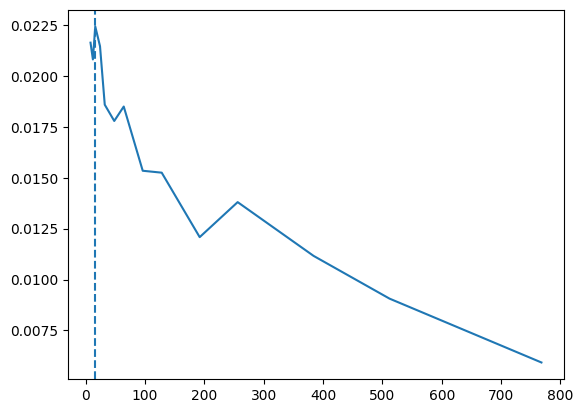

In [61]:
ax = pd.Series(svd_results).plot()
ax.axvline(best_svd_rank, ls='--')

# submit

In [63]:
training, testset, data_index_source = transform_data(
    training_source, testset_source, userid='userid', itemid='movieid'
)

data_description_source = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index_source['users']),
    n_items = len(data_index_source['items'])
)

best_config = {'rank': best_svd_rank}
item_factors = build_svd_model(best_config, training, data_description_source)
scores = svd_model_scoring(item_factors, testset, data_description_source)
recs = topn_recommendations(scores, topn=topn)

test_users_index = pd.Index(
    testset_source['userid'].drop_duplicates()
)

save_solution(recs, test_users_index, data_index_source['items'], 'submission.csv')

In [64]:
!kaggle competitions submit -c {competition_name} -f submission.csv -m 'my new submission'

['',
 '  0%|          | 0.00/620k [00:00<?, ?B/s]',
 ' 22%|██▏       | 136k/620k [00:00<00:00, 1.23MB/s]',
 ' 70%|██████▉   | 432k/620k [00:00<00:00, 561kB/s] ',
 '100%|██████████| 620k/620k [00:01<00:00, 339kB/s]',
 'Successfully submitted to Skoltech Recommender Systems Challenge 2023']

# 75 pts baseline

### grid-search

In [88]:
scalings = [0.35, 0.4, 0.45]

In [78]:
def ssvd_grid_search(ranks, scalings, training, testset, holdout, data_description, topn = 20):
    max_rank = max(ranks)
    config = {'rank': max_rank}
    results = {}
    for scaling in tqdm(scalings):
        config['scaling'] = scaling
        item_factors = build_ssvd_model(config, training, data_description)
        for rank in tqdm(ranks):
            item_factors_trunc = item_factors[:, :rank]
            scores = ssvd_model_scoring(item_factors_trunc, testset, data_description)
            recs = topn_recommendations(scores, topn=topn)
            results[(rank, scaling)] = evaluate(recs, holdout, data_description)
    return results

def build_ssvd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    scaled_matrix = rescale_matrix(source_matrix, config['scaling'])
    
    *_, vt = svds(scaled_matrix, k=config['rank'], return_singular_vectors='vh')
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def rescale_matrix(matrix, scaling_factor):
    freqs = matrix.getnnz(axis=0)
    scaling_weights = np.power(freqs, 0.5 * (scaling_factor - 1))
    return matrix.dot(diags(scaling_weights))
    
def ssvd_model_scoring(params, data, data_description):
    item_factors = params
    test_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    downvote_seen_items(scores, data, data_description)
    return scores

In [89]:
ssvd_results = ssvd_grid_search(
    ranks, scalings,
    train_val, testset_val, holdout_val,
    data_description, topn=20
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:16<00:00, 145.47s/it]


### best model

In [90]:
best_svd_param = pd.Series(ssvd_results).idxmax()
best_svd_param

(512, 0.35)

In [91]:
ssvd_results[best_svd_param]

0.02349343766780961

In [92]:
training, testset, data_index_source = transform_data(
    training_source, testset_source, userid='userid', itemid='movieid'
)

data_description_source = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index_source['users']),
    n_items = len(data_index_source['items'])
)

best_config = {'rank': best_svd_param[0], 'scaling': best_svd_param[1]}
item_factors = build_ssvd_model(best_config, training, data_description_source)
scores = ssvd_model_scoring(item_factors, testset, data_description_source)
recs = topn_recommendations(scores, topn=topn)

test_users_index = pd.Index(
    testset_source['userid'].drop_duplicates()
)

save_solution(recs, test_users_index, data_index_source['items'], 'submission.csv')

In [93]:
!kaggle competitions submit -c {competition_name} -f submission.csv -m 'my new submission'

100%|█████████████████████████████████████████| 633k/633k [00:01<00:00, 359kB/s]
Successfully submitted to Skoltech Recommender Systems Challenge 2023